# Лабораторная работа №6.

# Setup

In [6]:
# pip install noisereduce
# pip install librosa

In [74]:
import tarfile

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys

import librosa
import librosa.display

from sklearn.preprocessing import OneHotEncoder

from IPython.display import Audio
import noisereduce as nr

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 1. Загрузить датасет Dusha и сделать EDA анализ. За основу взять файл Задание_1_EDA_Dusha_dataset.ipynb



### Описание

В исходной неагрегированной таблице данных содержатся следующие поля:

audio_path — путь к аудиофайлу;

annotator_id — уникальный идентификатор разметчика, который оценивает эмоцию; 

annotator_emo — эмоция, которую указал разметчик;

golden_emo — эмоция контрольного задания;

speaker_text — текст, который произнёс диктор;

speaker_emo — эмоция, которую выражал диктор («заказанная» эмоция для разметчика-диктора из первой группы для семплов из Crowd, None для семплов из Podcasts);

source_id — уникальный идентификатор диктора или подкаста.

### Eda анализ

Основные шаги EDA включают в себя:

Загрузка данных: Получение данных из источника и их загрузка в среду анализа.

Понимание структуры данных: Изучение основных характеристик данных, таких как размеры, типы переменных, пропущенные значения и другие статистики.

Визуализация данных: Использование графиков и диаграмм для визуального представления данных. Это может включать в себя гистограммы, диаграммы рассеяния, ящики с усами и т. д.

Анализ зависимостей: Изучение взаимосвязей между переменными и выявление возможных зависимостей.

Обработка выбросов и пропущенных значений: Работа с выбросами (несколько необычных значений) и пропущенными данными, если они есть.

Извлечение статистических характеристик: Расчет основных статистических параметров, таких как среднее значение, медиана, стандартное отклонение и др.

In [ ]:
# !wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/dusha/crowd.tar

### Read files

In [21]:
def load_data(path, columns_to_drop=['hash_id', 'source_id']):
    df = pd.read_json(path, lines=True).drop(columns=columns_to_drop)
    df['audio_path'] = df['audio_path'].apply(lambda x: x[6:])
    df = df[df['annotator_emo'] != 'other']
    #df = df[df['duration'] <= 5.0]
    return df

In [9]:
tar_file_path = 'crowd.tar'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall()

print(f'Tar {tar_file_path} extracted')

Tar crowd.tar  extracted


In [11]:
tar_file_path = 'podcast.tar'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall()

print(f'Tar {tar_file_path} extracted')

Tar podcast.tar extracted


In [22]:
crowd_train = load_data('crowd_train/raw_crowd_train.jsonl')
crowd_test = load_data('crowd_test/raw_crowd_test.jsonl')
podcast_train = load_data('podcast_train/raw_podcast_train.jsonl')
podcast_test = load_data('podcast_test/raw_podcast_test.jsonl')

In [81]:
crowd_train

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo
0,75e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry
1,f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral
2,937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,None,None
3,b0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral
4,96dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral
...,...,...,...,...,...,...,...
906948,c1e379757b50ea57ba0d86fa2cfbc2e.wav,4.159625,sad,2.0,cff125aa5153b7677dd28377337dcd2f,индийские фильмы индийские,sad
906949,923edeb05adcebc215d9ae9d9655a0a.wav,3.784438,neutral,2.0,cff125aa5153b7677dd28377337dcd2f,сериал метро,sad
906950,5dd4c4fd8f9e1f6f2b77041e0a69fe4.wav,2.722938,neutral,2.0,6a059476b07f0467b9474fc47537784e,смотреть ужасы про крыс,sad
906951,93277832bed252bf5f321223d5d08f4.wav,3.349000,neutral,NaN,6a059476b07f0467b9474fc47537784e,мороженщик в реальной жизни,neutral


In [82]:
crowd_test

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo
0,e9961c53ca6eeb440b217e539fbf46c.wav,5.82000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,я слушаю,neutral
1,166f65a30354db8282682b1a280e64c.wav,3.70000,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,каким стал сбер,neutral
2,49a6b560155831725a7bdc7d0a96099.wav,4.38000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,где родился шерлок холмс,neutral
3,6852b0925797612d7b6724da8cbe7b4.wav,8.58000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,открой в браузере ennio morricone,neutral
4,166f65a30354db8282682b1a280e64c.wav,3.70000,sad,NaN,a5562e26cd8f1949488a2d1e1e549d97,каким стал сбер,neutral
...,...,...,...,...,...,...,...
79083,c0dddce6a86f7fe9c017c03a299773e.wav,4.92000,sad,3.0,f37940680d604692ea541b439fa39762,None,None
79084,893d560e540c0c34de1ec9a779bde67.wav,3.86000,neutral,2.0,3f2111910c469da2869d8f4178c4a945,None,None
79085,9baaf6ed01355a799311d49121e0a0f.wav,7.24425,sad,3.0,b9413991d11e08bb636c1ce2aeedb1c2,None,None
79086,ca882b01aa79b7a75bd2e8acb2373f9.wav,4.92000,sad,3.0,0f138ca8a0ce058f48d47cda85753439,None,None


### Анализ

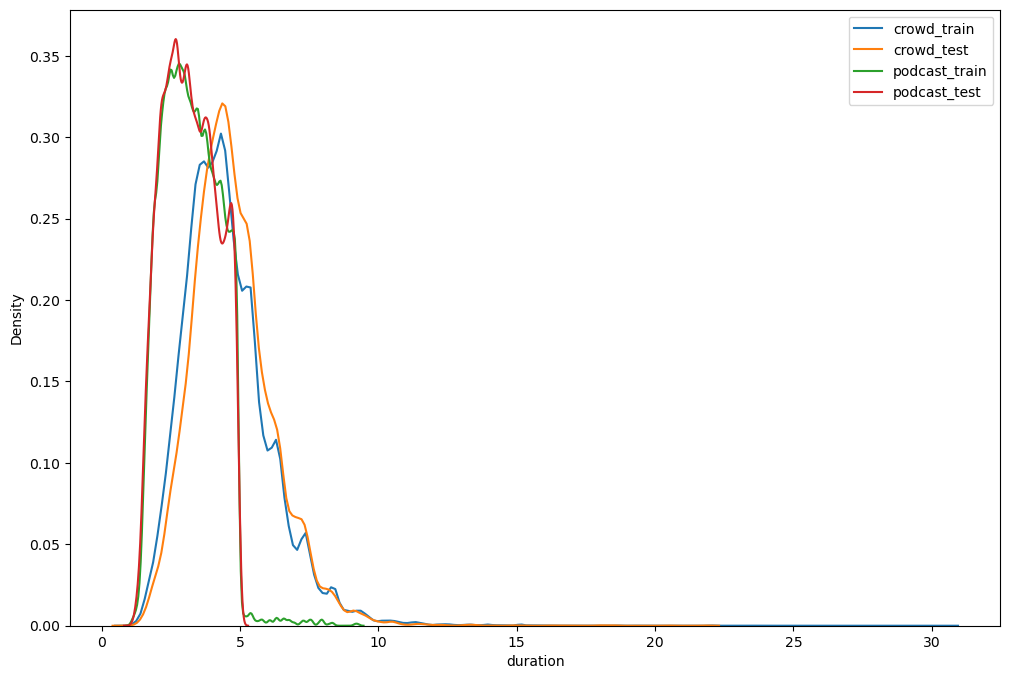

In [24]:
plt.figure(figsize=(12, 8))
sns.distplot(crowd_train['duration'], label='crowd_train', hist=False)
sns.distplot(crowd_test['duration'], label='crowd_test', hist=False)
sns.distplot(podcast_train['duration'], label='podcast_train', hist=False)
sns.distplot(podcast_test['duration'], label='podcast_test', hist=False)
plt.legend()

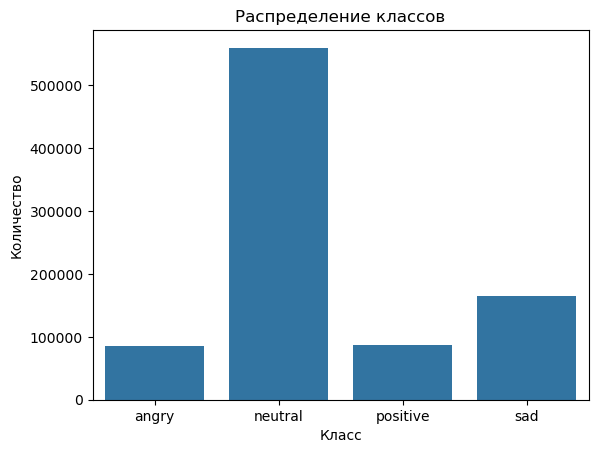

In [30]:
sns.countplot(x='annotator_emo', data=crowd_train)

plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Распределение классов')

plt.show()

In [31]:
crowd_train['annotator_emo'].value_counts()

annotator_emo
neutral     559501
sad         164671
positive     87258
angry        85527
Name: count, dtype: int64

### Sample

In [67]:
import wave

with wave.open(r'crowd_train/wavs/7f8cfd19f860eff13b2a9cad8b01973f.wav', "rb") as wave_file:
    sampling_rate = wave_file.getframerate()
    print(f"Sample rate: {sampling_rate}")

Sample rate: 16000


In [70]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar()

def create_mfcc(data, sr, e):
    plt.figure(figsize=(11, 3))
    mfcc = librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()
    plt.show()
    plt.plot(np.mean(mfcc.T, axis=0))
    plt.show()
    return mfcc

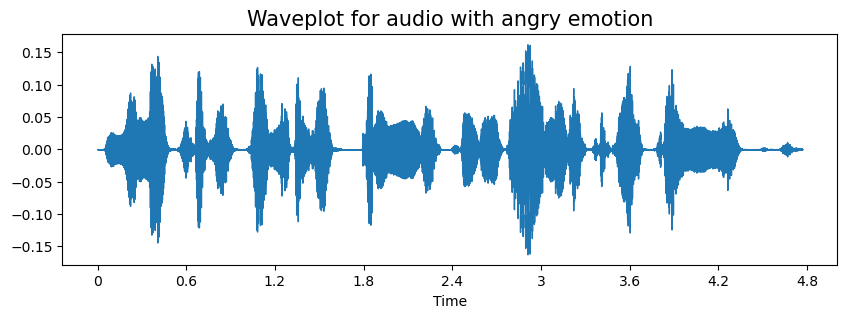

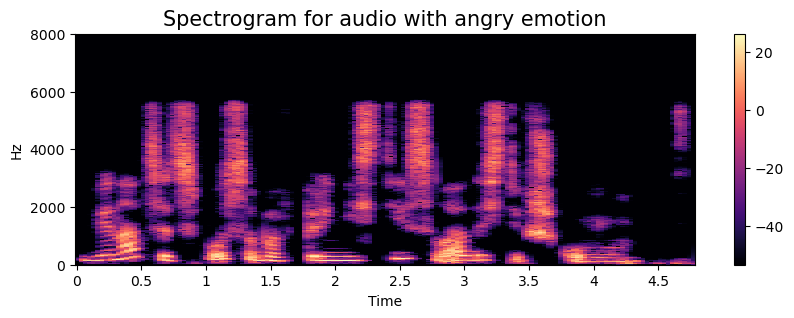

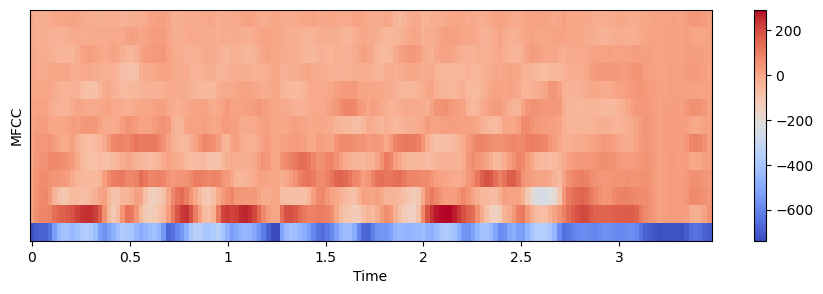

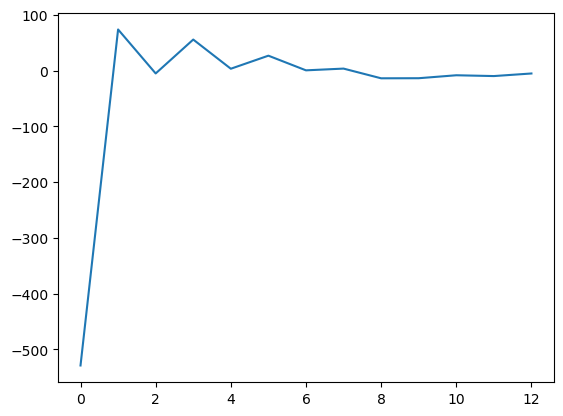

In [71]:
path = 'crowd_train/wavs/7f8cfd19f860eff13b2a9cad8b01973f.wav'
data, sr = librosa.load(path)
data = nr.reduce_noise(data, sr=sr)
xt, index = librosa.effects.trim(data, top_db=33)
display(Audio(xt, rate=sr))
create_waveplot(xt, sampling_rate, emo)
create_spectrogram(xt, sampling_rate, emo)
mfcc_p = create_mfcc(xt, sampling_rate, emo)

Для обучения нам нужны wavs, но в dataframe их гораздо больше! Так что лишние записи предется убрать

In [80]:
crowd_train_wavs = os.listdir(path="/Users/kirillanpilov/NLP_FU/Lab6/crowd_train/wavs")
crowd_test_wavs = os.listdir(path="/Users/kirillanpilov/NLP_FU/Lab6/crowd_test/wavs")

In [87]:
crowd_train_wavs

['72c4d9c0dc373170358559e885988dbe.wav',
 '9d4c4915f16c6c94cea6da05c48278de.wav',
 'cad4cda33f9f10b35740168a0c080a70.wav',
 'f9c70cd0915d2b3149e946bd3533896f.wav',
 '0a1c815512a9e9702a2d9bc27765363f.wav',
 '6c3837d2fbf7b56e4039a059504d2051.wav',
 'c8a8be109a45954c529cf27c2c79bd23.wav',
 'fd5c1798db11b60a1bf6551e12a24ba6.wav',
 'bf666ea45f971afdd966a64572b48c38.wav',
 'aa40ad88595d0e505702da704c8fa02a.wav',
 '24d192fedfe8100934b1c93b35ac6fc5.wav',
 'a0deb57b9e4bc6bad3fa8b07d6e807ad.wav',
 '6e12e89ec57b7050399da893b0b7f1b2.wav',
 '3a16f43b426cc88c274aba678879606f.wav',
 '65d1b89bd1ddb5bd9ebcadc67dbbb478.wav',
 'eb1bce044c0d7bbc25fac39e212b162b.wav',
 '91e7741a6b0ebed36f6d32457ffe3bc4.wav',
 'f7595e04be3100e5af9f637d6a19534b.wav',
 '8155e231579ff92b3ca8bace4f934abe.wav',
 'f83128916aa471808e25249f3fb3656c.wav',
 '83eb4b56c0794e9a028a0c303636f23e.wav',
 'f48bc911a815d59ca46bf0fb347ce5ee.wav',
 '24c6f45dcad6e709d7c32c46494737ed.wav',
 '8c05a790b92755e6b60cea1c83fc8650.wav',
 '67cf6bf3ea336a

In [86]:
mask = crowd_train['audio_path'].isin(crowd_train_wavs)
sum(mask)

0

In [90]:
crowd_train['audio_path'] == '72c4d9c0dc373170358559e885988dbe.wav'

0         False
1         False
2         False
3         False
4         False
          ...  
906948    False
906949    False
906950    False
906951    False
906952    False
Name: audio_path, Length: 896957, dtype: bool

## 2. Решить задачу классификации классическими методами машинного обучения.

In [ ]:
class SoundDataset(Dataset):

    def __init__(self, dataframe, audio_dir):
        self.df = df
        self.audio_dir = audio_dir
        
        

    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        return signal , label

    def _get_audio_sample_path(self, index):
        path = df.iloc[index,0]
        return path

    def _get_audio_sample_label(self, index):
        return
        
        
        

## 3. Решить задачу классификации, использовав различные архитектуры нейронных сетей, включая HuBERT. За основу взять файлы CNN-LSTM_SER_model.ipynb и Hubert-SER_model.ipynb


## 4. Разработать систему онлайн записи аудиофайлов и ее транскрибации с использованием Whisper (https://github.com/openai/whisper/)


## 5.	Примените ruBERT для анализа тональности текста Сделать выводы по каждому из заданий!!! Примечание!!! Если не хватает вычислительных ресурсов для работы с датасетом Dusha, то можно использовать датасет, в котором объединены датасеты SAVEE и TESS)